In [ ]:
# 参考：zhangxiangxu

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1 读入数据并预览

In [4]:
train = pd.read_csv('data/train.tsv.zip', sep='\t')
test = pd.read_csv('data/test.tsv.zip', sep='\t')

In [5]:
train.head(5)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [6]:
train.shape

(156060, 4)

In [7]:
test.head(5)

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [8]:
train.Sentiment.value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

<AxesSubplot:title={'center':'分布情况'}, xlabel='Sentiment', ylabel='count'>

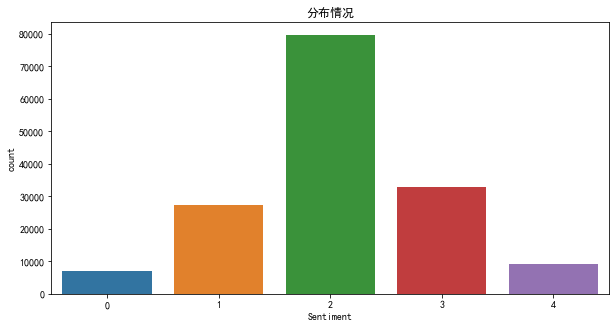

In [9]:
plt.figure(figsize=(10, 5))
ax = plt.axes()
ax.set_title('分布情况')
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False
sns.countplot(x=train.Sentiment, data=train)

In [10]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [11]:
# maketrans&translate的使用：  https://blog.csdn.net/jpch89/article/details/86759980
train['Phrase1'] = train.Phrase.apply(lambda x: x.translate(str.maketrans('','', string.punctuation)).lower())
#str.maketrans('','', string.punctuation))使用了三个参数，前两个参数是转换，这里没有使用
#第三个参数中出现的字符将被转为None
test['Phrase1'] = test.Phrase.apply(lambda x: x.translate(str.maketrans('','', string.punctuation)).lower())

In [12]:
train.head(5)

,PhraseId,SentenceId,Phrase,Sentiment,Phrase1
0,1,1,A series of escapades demonstrating the adage ...,1,a series of escapades demonstrating the adage ...
1,2,1,A series of escapades demonstrating the adage ...,2,a series of escapades demonstrating the adage ...
2,3,1,A series,2,a series
3,4,1,A,2,a
4,5,1,series,2,series


# 2 文本特征表示并保存

In [13]:
def convert_to_one_hot(series, c):
    """
    输入一个series，内容为整数，转为独热向量矩阵，维度为c*样本数
    参数：
    series：df中包含Sentiment的一列
    c：类别数，int
    返回：
    Y：独热向量矩阵，c*样本数
    """
    num = series.shape[0]
    Y = np.eye(c)[np.array(series).reshape(-1)].T
    assert Y.shape == (c, num)
    return Y

In [14]:
def create_dictionary(df):
    """
    输入数据df，建立词袋，给数据df增添一个新的列Set_of_word，里面包含该样本中所含有的词汇，同时返回一个包含所有词汇的列表
    """
    df['Set_of_word'] = df.Phrase1.apply(lambda x: set(x.split()))
    bag_of_word = set()
    for _, value in df.Set_of_word.items():
        bag_of_word |= value
    return list(bag_of_word)

In [15]:
def function(x, n):
    """
    用于create_couple_dictionary生成词组
    """
    temp = [x.split()[i: i + n] for i in range(len(x.split()) - n + 1)]
    res = tuple(t for t in set(tuple(_) for _ in temp))
    return res

In [16]:
def create_couple_dictionary(df, n):
    """
    输入数据df，建立词组袋，给数据df增添一个新的列Set_of_word_couple，里面包含该样本中所含有的词组，同时返回一个包含所有词组的列表
    参数：
    df：DataFrame, 大小为156060*5，包含所有数据
    n：词组的个数
    """
    df['Set_of_word_couple'] = df.Phrase1.apply(function, n=n)
    bag_of_word_couple = set()
    for _, value in df.Set_of_word_couple.items():
        bag_of_word_couple |= set(value)
    return list(bag_of_word_couple)

In [17]:
def bag_of_word(df):
    """
    根据数据表格，生成包含所有词的列表,对于每行数据，根据其中包含的词构建词袋向量
    参数：
    df：DataFrame, 大小为156060*5，包含所有数据，至少有五列：PhraseId，SentenceId，Phrase，Sentiment，Phrase1，运行结束后增加一列Set_of_word
    返回：
    word_matrix：包含词袋向量的矩阵，维度为词汇量*样本量
    word_to_index：一个词对→索引的字典
    index_to_word：一个索引→词对的字典
    """
    amount, _ = df.shape
    bag_of_word = create_dictionary(df)  # 词袋列表，同时给df增加一个新的列Set_of_word
    dimension = len(bag_of_word)
    # 设置一个矩阵，用来盛放每条数据的词袋向量，顺序与df一致，大小为词汇数量*样本数量
    word_matrix = np.zeros((dimension, amount), dtype='i1') # int8
    # 遍历数据，填充word_matrix，对于每一行的样本，先将其按照单词拆为列表，然后找到每个单词在word_matrix中的位置，将其数值加1
    word_to_index = {}  # 一个词汇→索引的字典
    index_to_word = {}  # 一个索引→词汇的字典
    for row in df.itertuples():
        index = getattr(row, 'Index')
        temp_list = getattr(row, 'Phrase1').split()  # 得到的是列表类型
        for word in temp_list:
            # 确定单词在词袋中的位置
            if word_to_index.get(word, -1) < 0:
                position = bag_of_word.index(word)
                word_to_index[word] = position
                index_to_word[position] = word
            else:
                position = word_to_index.get(word, -1)
            # 修改word_matrix
            word_matrix[position][index] += 1
    assert word_matrix.shape == (len(bag_of_word), df.shape[0])
    return word_matrix, word_to_index, index_to_word

In [18]:
def n_gram(df, n):
    """
     根据数据表格，生成包含所有词组的列表,对于每行数据，根据其中包含的词组构建词袋向量
     参数：
     df：DataFrame, 大小为156060*5，包含所有数据，至少有五列：PhraseId，SentenceId，Phrase，Sentiment，Phrase1，运行结束后增加一列Set_of_word_couple
     n：每个组合中包含词的数量
     返回：
     word_matrix：包含词袋向量的矩阵，维度为词汇量*样本量
     couple_to_index：一个词对→索引的字典
     index_to_couple：一个索引→词对的字典
    """
    amount, _ = df.shape
    bag_of_word = create_couple_dictionary(df, n=2)  # 词袋列表，同时给df增加一个新的列Set_of_word
    dimension = len(bag_of_word)
    # 设置一个矩阵，用来盛放每条数据的词袋向量，顺序与df一致，大小为词汇数量*样本数量
    word_matrix = np.zeros((dimension, amount), dtype='i1')
    # 遍历数据，填充word_matrix，对于每一行的样本，先将其按照单词拆为列表，然后找到每个单词在word_matrix中的位置，将其数值加1
    couple_to_index = {}  # 一个词汇→索引的字典
    index_to_couple = {}  # 一个索引→词汇的字典
    for row in df.itertuples():
        index = getattr(row, 'Index')
        temp = getattr(row, 'Phrase1').split()  
        temp_list = [tuple(temp[i: i + n]) for i in range(len(temp) - n + 1)]# 得到的是列表类型
        for couple in temp_list:
            # 确定单词在词袋中的位置
            if couple_to_index.get(couple, -1) < 0:
                position = bag_of_word.index(couple)
                couple_to_index[couple] = position
                index_to_couple[position] = couple
            else:
                position = couple_to_index.get(couple, -1)
            # 修改word_matrix
            word_matrix[position][index] += 1
        if index % 100 == 0:
            print(f'{index/amount * 100:.2f}%', end='\r')
    assert word_matrix.shape == (len(bag_of_word), df.shape[0])
    return word_matrix, couple_to_index, index_to_couple

In [19]:
def feature_select(X, threshold=.8*(1-.8)):
    """
    删除方差较小的特征
    参数：
    X：array，d*n
    threshold：标量，阈值
    返回：
    X_selected：array,选择后的特征
    idx: 删除的下标
    """
    d, n = X.shape
    var = np.var(X, axis=1).reshape((d, 1))
    mask = var > threshold
    temp = mask * X
    idx = np.argwhere(np.all(temp[..., :] == 0, axis=1))
    X_selected = np.delete(X, idx, axis=0)
    
    return X_selected, idx

In [20]:
a = np.random.randn(5,4)
b, idx = feature_select(a, 0.7)
print(a, end='\n\n')
print(b)

[[-0.22096991  1.18425384 -1.85350399  0.07914185]
 [-0.62877822 -1.92374444 -2.66443713 -0.65221616]
 [ 1.52419647  0.70317894 -1.24320864  0.36069842]
 [-2.43249082  0.25646575  0.34521819 -0.33455549]
 [ 0.50673148 -0.95581905  1.34438223 -1.52558943]]

[[-0.22096991  1.18425384 -1.85350399  0.07914185]
 [-0.62877822 -1.92374444 -2.66443713 -0.65221616]
 [ 1.52419647  0.70317894 -1.24320864  0.36069842]
 [-2.43249082  0.25646575  0.34521819 -0.33455549]
 [ 0.50673148 -0.95581905  1.34438223 -1.52558943]]


In [21]:
# 验证词袋
data = train
word_matrix_raw, word_to_index, index_to_word = bag_of_word(data)

In [22]:
word_matrix_raw.shape

(16403, 156060)

In [23]:
# 特征选择
word_matrix, idx = feature_select(word_matrix_raw, 0.001)
word_matrix.shape

(735, 156060)

In [35]:
# 打乱样本
Y = convert_to_one_hot(data.Sentiment, 5)
np.random.seed(1)
permutation = np.random.permutation(word_matrix.shape[1])
Y_shuffle = Y[:, permutation]
word_matrix_shuffle = word_matrix[:, permutation]

# 划分训练集、验证集
split1 = int(0.7 * word_matrix.shape[1])
split2 = int(0.85 * word_matrix.shape[1])
train_X = word_matrix_shuffle[:, 0: split1]
train_Y = Y_shuffle[:, 0: split1]
valid_X = word_matrix_shuffle[:, split1: split2]
valid_Y = Y_shuffle[:, split1: split2]
test_X = word_matrix_shuffle[:, split2:]
test_Y = Y_shuffle[:, split2:]

In [36]:
np.savez('.\data\matrix_bag_of_word_filter.npz', train_X, train_Y, valid_X, valid_Y, test_X, test_Y)

In [ ]:
# 验证ngram
data = train
word_matrix, couple_to_index, index_to_couple = n_gram(data, 2)
Y = convert_to_one_hot(data.Sentiment, 5)
print("矩阵填充结束，开始打乱")
# 打乱样本
permutation = np.random.permutation(word_matrix.shape[1])
word_matrix_shuffle = word_matrix[:, permutation]
Y_shuffle = Y[:, permutation]
print("打乱完毕，开始划分数据")
# 划分训练集、验证集
split1 = int(0.7 * word_matrix.shape[1])
split2 = int(0.85 * word_matrix.shape[1])
train_X = word_matrix_shuffle[:, 0: split1]
train_Y = Y_shuffle[:, 0: split1]
valid_X = word_matrix_shuffle[:, split1: split2]
valid_Y = Y_shuffle[:, split1: split2]
test_X = word_matrix_shuffle[:, split2:]
test_Y = Y_shuffle[:, split2:]


np.savez('.\data\matrix_n_gram_2.npz', train_X, train_Y, valid_X, valid_Y, test_X, test_Y)

矩阵填充结束，开始打乱


# 3 模型构建

In [ ]:
# 计算softmax
def softmax(X):
    """
    计算softmax值
    :param X: array
    :return: s：array，float32，维度与X相同
    """
    s = np.exp(X) / np.sum(np.exp(X), axis=0)
    assert s.shape == X.shape
    return s

In [ ]:
# 初始化
def parameter_normalize(c, d):
    """
    初始化权重W（d * c），b（c * 1)
    参数：
    d：维度
    n：维度
    c：种类
    
    返回：
    W，b
    """
    np.random.seed(1)
    W = np.random.randn(d, c)
    b = np.zeros((c, 1))
    
    return W, b

In [ ]:
# 创建mini_batch
def create_mini_batches(X, Y, batch_size, seed):
    """
    参数：
    X：输入, d * n
    Y：标签, c * n
    batch_size：大小，标量
    seed：随机种子，标量
    
    返回：
    mini_batches：包含mini_batch的列表，内部是（mini_batch_X, mini_batch_Y）
    """
    n = X.shape[1]
    mini_batches = []
    num_of_batches = int(n / batch_size)
    for k in range(0, num_of_batches):
        mini_batch_X = X[:, k * batch_size: (k + 1) * batch_size]
        mini_batch_Y = Y[:, k * batch_size: (k + 1) * batch_size]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    if n % num_of_batches != 0:
        mini_batch_X = X[:, num_of_batches * batch_size:]
        mini_batch_Y = Y[:, num_of_batches * batch_size:]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [ ]:
# 前向传播
def forward(X, parameter, cache):
    """
    执行前向传播，Z = W.T*X + b
    :param X: 输入，array，dimension * batch_size
    :param parameter：包含参数W，b的字典
        W: 权重矩阵，array，d * c
        b: 偏置，array，c * 1
    :param cache: 盛放Z，Y_hat的字典
    
    :return: cache：包含Z，Y_hat的字典
    """
    
    W = parameter['W']
    b = parameter['b']
    
    Z = np.dot(W.T, X) + b
    Y_hat = softmax(Z)
    
    cache['Z'] = Z
    cache['Y_hat'] = Y_hat
    assert Z.shape == (W.shape[1], X.shape[1])
    return cache

In [ ]:
# 计算损失
def compute_loss(Y, Y_hat, lamda, parameter):
    """
    计算损失
    :param Y_hat: array，预测值，c * batch_size
    :param Y: array，标签，one_hot矩阵，c * batch_size
    :param parameter:包含参数W，b的字典
    :return: L，标量
    """
    W = parameter['W']
#     Y_hat = cache['Y_hat']
    
    n = Y.shape[1]
    l = - np.sum(Y * np.log(Y_hat), axis=0)
    # 加入正则项
    loss = np.sum(l) / n + 1 / 2 / n * lamda * np.square(np.linalg.norm(W))
    
    return loss

In [ ]:
# 计算梯度
def backward(X, Y, cache):
    """
    计算梯度
    cache：包含参数Z，Y_hat的字典
    X: array, float, d * n
    Y: array, float, c * n
    
    return：一个包含梯度dW,db的字典，维度与W，b相同
    """
    Y_hat = cache['Y_hat']
    n = X.shape[1]
    
    # 计算梯度
    dW = - np.dot(X, (Y - Y_hat).T) / n
    db = - np.sum((Y - Y_hat), axis=1) / n
    
    gradient = {}
    gradient['dW'] = dW
    gradient['db'] = db
    
    return gradient

In [ ]:
# 参数更新
def update_gradient(parameter, gradient, learning_rate, lamda, belta1, belta2, epsilon, t, n, opt='SGD'):
    """
    反向传播
    参数：
    parameter：包含参数W，b, m_W, v_W, m_b, v_b的字典
        W: 权重矩阵，float，d * c
        b：偏置，float，c * 1
    gradient：包含梯度的字典
    learning_rate：学习率
    lamda：正则化系数
    #t: 当前进行下降的次数
    
    返回：
    parameter：包含参数W，b的字典
    """
    dW = gradient['dW']
    db = gradient['db']
    W = parameter['W']
    b = parameter['b']
    m_W = parameter['m_W']
    v_W = parameter['v_W']
    m_b = parameter['m_b']
    v_b = parameter['v_b']
    c = W.shape[1]
    d = W.shape[0]
    n = W.shape[1]
    dW = dW.reshape((d, c))
    db = db.reshape((c, 1))
#     print("开始")
#     print(b.shape,db.shape)
    if opt == 'Adam':
        # 更新
        m_W = belta1 * m_W + (1 - belta1) * dW
        v_W = belta2 * v_W + (1 - belta2) * np.square(dW)
        m_W_hat = m_W / (1 - np.power(belta1, t))
        v_W_hat = v_W / (1 - np.power(belta2, t))
        W = W - np.multiply(learning_rate / (np.sqrt(v_W_hat) + epsilon),  m_W_hat)

        m_b = belta1 * m_b + (1 - belta1) * db
        v_b = belta2 * v_b + (1 - belta2) * np.square(db)
        m_b_hat = m_b / (1 - np.power(belta1, t))
        v_b_hat = v_b / (1 - np.power(belta2, t))
        b = b - np.multiply(learning_rate / (np.sqrt(v_b_hat) + epsilon),  m_b_hat)
    elif opt == 'SGD':
        W = W - learning_rate * (dW + 1 / n * lamda * W)
        b = b - learning_rate * (db + 1 / n * lamda * b)
    assert W.shape == dW.shape
#     print(b.shape, db.shape)
    assert b.shape == db.shape
    
    parameter['W'] = W
    parameter['b'] = b
    parameter['m_W'] = m_W
    parameter['v_W'] = v_W
    parameter['m_b'] = m_b
    parameter['v_b'] = v_b
    
    return parameter

In [ ]:
def model(train_data, test_data, num_epochs=1000, batch_size=64, learning_rate=0.001, belta1 = 0.9, belta2 = 0.999, epsilon = 1e-8, lamda=0.1, opt='SGD', if_print=True):
    """
    进行训练
    参数：
    X：训练数据
    Y：标签
    epoch：训练次数
    batch_size：batch大小
    learning_rate：学习率
    lamda：正则化系数
    """
    X = train_data[0]
    Y = train_data[1]
    
    test_X = test_data[0]
    test_Y = test_data[1]
    
    d = X.shape[0]
    c = Y.shape[0]
    losses = []
    test_losses = []
    # 初始化参数
    W, b = parameter_normalize(c, d)
    m_W = 0
    v_W = 0
    m_b = 0
    v_b = 0
    parameter = {}
    cache = {}
    gradient = {}
    parameter['W'] = W
    parameter['b'] = b
    parameter['m_W'] = m_W
    parameter['v_W'] = v_W
    parameter['m_b'] = m_b
    parameter['v_b'] = v_b
    
    # 创建mini_batch
    mini_batches = create_mini_batches(X, Y, batch_size, seed=1)
    t = 0
    for i in range(num_epochs):
        seed = 0
        np.random.seed(seed)
        permutation = np.random.permutation(len(mini_batches))
#         print(permutation)
        mini_batches = np.array(mini_batches, dtype=object)[permutation]
        for mini_batch in mini_batches:
            t += 1
            mini_batch_X, mini_batch_Y = mini_batch
            cache = forward(mini_batch_X, parameter, cache)  # 包含Z，Y_hat
            Y_hat = cache['Y_hat']
            loss = compute_loss(mini_batch_Y, Y_hat, lamda=lamda, parameter=parameter)
            gradient = backward(mini_batch_X, mini_batch_Y, cache)  # 包含dW，db
            parameter = update_gradient(parameter, gradient, learning_rate=learning_rate, belta1 = belta1, belta2 = belta2, epsilon = epsilon, lamda=lamda, n=mini_batch_X.shape[1], t=t, opt=opt)
            
        seed += 1
        
        if i % 10 == 0:
            
            losses.append(loss)
            Y_hat = forward(X, parameter, cache)['Y_hat']
            preds = np.equal(Y_hat, np.max(Y_hat, axis=0))
            true = Y
            correct_prediction = np.equal(preds, true)
            
            
            
            test_Y_hat = forward(test_X, parameter, cache)['Y_hat']
            preds = np.equal(test_Y_hat, np.max(test_Y_hat, axis=0))
            true = test_Y
            correct_prediction = np.equal(preds, true)
            test_loss = compute_loss(true, test_Y_hat, lamda=lamda, parameter=parameter)
            test_losses.append(test_loss)
            if if_print:
                print(f"已运行{i}次，当前损失为：" + str(loss), end=', ')
                print(f"当前训练集准确率为：{np.mean(correct_prediction) * 100:.2f}%")
                print(f"当前测试集损失为：{test_loss}", end=', ')
                print(f"当前测试集准确率为：{np.mean(correct_prediction) * 100:.2f}%")
    W = parameter['W']
    b = parameter['b']
    
    return parameter, losses

# 4 模型训练

In [ ]:
# 读入预处理好的数据
# 词袋
matrix = np.load('.\data\matrix_bag_of_word.npz')

train_X = matrix['arr_0']
train_Y = matrix['arr_1']
valid_X = matrix['arr_2']
valid_Y = matrix['arr_3']
test_X = matrix['arr_4']
test_Y = matrix['arr_5']

train = (train_X, train_Y)
test = (test_X, test_Y)

# n-gram
matrix_ngram = np.load('.\data\matrix_n_gram_2.npz')

g_train_X = matrix_ngram['arr_0']
g_train_Y = matrix_ngram['arr_1']
g_valid_X = matrix_ngram['arr_2']
g_valid_Y = matrix_ngram['arr_3']
g_test_X = matrix_ngram['arr_4']
g_test_Y = matrix_ngram['arr_5']

g_train = (g_train_X, g_train_Y)
g_test = (g_test_X, g_test_Y)

In [ ]:
# 词袋特征--模型向量
# 测试参数更新策略对训练效果的影响
# 使用SGD
loss = []
lrs = [0.1, 0.01, 0.001, 0.0001]
for lr in lrs:
    _, losses = model(train, test, num_epochs=300, batch_size=64, learning_rate=lr, belta1 = 0.9, belta2 = 0.999, epsilon = 1e-8, lamda=0, if_print=False)
    loss.append(losses)

line = ['-', '--', '-.', ':']
color = ['red', 'blue', 'green', 'skyblue']
plt.figure()
plt.title("Different Learning Rates",fontsize = 24)
plt.ylabel("Loss",fontsize = 14)
plt.xlabel("ten epochs",fontsize = 14)
for i in range(4):
    plt.plot(loss[i], color=color[i], linestyle=line[i], label=f'learning_rate={lrs[i]}')
plt.legend()
plt.savefig('.\\data\\test_bag_of_word_sgd.png')

In [ ]:
# 使用Adam
loss = []
lrs = [0.1, 0.01, 0.001, 0.0001]
for lr in lrs:
    _, losses = model(train, test, num_epochs=300, batch_size=64, learning_rate=lr, belta1 = 0.9, belta2 = 0.999, epsilon = 1e-8, lamda=0, opt='Adam', if_print=False)
    loss.append(losses)

line = ['-', '--', '-.', ':']
color = ['red', 'blue', 'green', 'skyblue']
plt.figure()
plt.title("Different Learning Rates",fontsize = 24)
plt.ylabel("Loss",fontsize = 14)
plt.xlabel("ten epochs",fontsize = 14)
for i in range(4):
    plt.plot(loss[i], color=color[i], linestyle=line[i], label=f'learning_rate={lrs[i]}')
plt.legend()
plt.savefig('.\\data\\test_bag_of_word_adam.png')

In [ ]:
# n-gram特征--模型向量
# 测试参数更新策略对训练效果的影响
# 使用SGD
loss = []
lrs = [0.1, 0.01, 0.001, 0.0001]
for lr in lrs:
    _, losses = model(g_train, g_test, num_epochs=150, batch_size=64, learning_rate=lr, belta1 = 0.9, belta2 = 0.999, epsilon = 1e-8, lamda=0, if_print=False)
    loss.append(losses)

line = ['-', '--', '-.', ':']
color = ['red', 'blue', 'green', 'skyblue']
plt.figure()
plt.title("Different Learning Rates",fontsize = 24)
plt.ylabel("Loss",fontsize = 14)
plt.xlabel("ten epochs",fontsize = 14)
for i in range(4):
    plt.plot(loss[i], color=color[i], linestyle=line[i], label=f'learning_rate={lrs[i]}')
plt.legend()
plt.savefig('.\\data\\ngram_sgd.png')

In [ ]:
loss = []
lrs = [0.1, 0.01, 0.001, 0.0001]
for lr in lrs:
    _, losses = model(g_train, g_test, num_epochs=150, batch_size=64, learning_rate=lr, belta1 = 0.9, belta2 = 0.999, epsilon = 1e-8, lamda=0, opt='Adam', if_print=False)
    loss.append(losses)

line = ['-', '--', '-.', ':']
color = ['red', 'blue', 'green', 'skyblue']
plt.figure()
plt.title("Different Learning Rates",fontsize = 24)
plt.ylabel("Loss",fontsize = 14)
plt.xlabel("ten epochs",fontsize = 14)
for i in range(4):
    plt.plot(loss[i], color=color[i], linestyle=line[i], label=f'learning_rate={lrs[i]}')
plt.legend()
plt.savefig('.\\data\\ngram_adam.png')

# 测试

In [13]:
a = set((1, 2, 3))
b= set((2, 4))

In [14]:
a|b

{1, 2, 3, 4}

In [15]:
tuple("明天")

('明', '天')